# Image Classification: Sloth vs Pastry

# Package Imports

In [67]:
# Package imports go here
import numpy as np
import matplotlib.pyplot as plt

import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

## Initalizations
For faster runtime

In [68]:
# Enable cudnn benchmark
cudnn.benchmark = True

# Reading and transforming the data

We'll begin loading and transforming our data by defining the specific transforms we'd like to use from `torchvision`.

Loading and transforming data to use `torchvision`.


In [70]:
# Create data transforms
# images could be in any size, shape or form
# want to standardize so that theyre all consistent
# transform into way to help model. seperate training and val
data_transforms = {
    "train" : transforms.Compose(
        [
            # resize into 224 pixels  square and randomized
            transforms.RandomResizedCrop(224),
            # flip them horizontally sometime, so that its random and good for new images
            transforms.RandomHorizontalFlip(),
            # images as np.arrays want in tensor as torch uses that
            transforms.ToTensor(),
            # Standardize variabiulity, sub mean / std, use these values cause resnet model trained on these means and std
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    ),
    "val" : transforms.Compose(
        [
            # only shape
            transforms.Resize(256),
            #only see center of image
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
}

Set the Data for training and testing

In [71]:
# Provide data directory
data_dir = "data/sloths_versus_pain_au_chocolat"

# Create image folders for our training and validation data 
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                           data_transforms[x]
                           )
    for x in ["train", "val"]
}

# Obtain dataset sizes from image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

# Obtain class_names from image_datasets
class_names = image_datasets["train"].classes
# print(class_names)

# Use image_datasets to sample from the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size = 4,
                                             shuffle=True)
               for x in ["train", "val"]
                                             }



In [72]:
# Change selected device to CUDA, a parallel processing platform, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualizing sloths and pastries with a custom function

## Defining the function

In [73]:
def imshow(inp, title=None):
    """
    This function will make use of Matplotlib.pyplot's imshow() function for tensors. 
    It will show the same number of images as the batch we defined.
    """
    # A transpose is required to get the images into the correct shape
    inp = inp.numpy().transpose((1, 2, 0))

    # Using default values for mean and std but can customize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    
    # To visualize the correct colors, reverses normalized
    inp = std * inp + mean
    
    # To view a clipped version of an image  
    inp = np.clip(inp, 0, 1)
    
    # Visualize inp
    plt.imshow(inp)
    
    if title is not None: # Plot title goes here
        plt.title(title)
       
 # Enables the function to pause while the plots are updated
plt.pause(0.001)


## Calling `imshow()` function

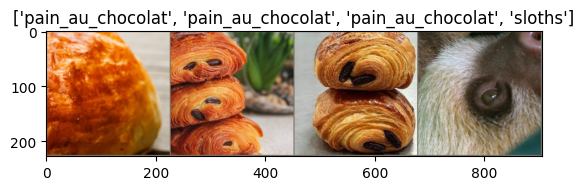

In [74]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title = [class_names[x] for x in classes])

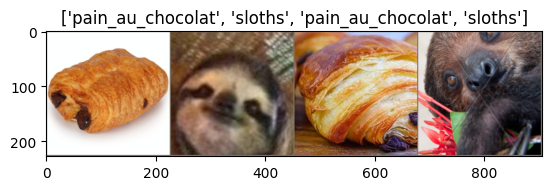

In [75]:
# Get a batch of validation data
inputs, classes = next(iter(dataloaders["val"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title = [class_names[x] for x in classes])

# Running the model with 25 epochs

## Functions for training the model and visualizing model results

In [80]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    '''
    Function that will train model based on data provided.
    '''
    
    since = time.time()

    # Make a deep copy of the model provided     
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data using the dataloader we defined
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass, tracking history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Computing loss statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Create a deep copy of the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print() # Print an empty line for nice formatting

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [77]:
def visualize_model(model, num_images=6):
    '''
    Function that will visualize results of the model
    '''
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Loading a pre-trained model

We'll use a model called ResNet18, developed by authors [Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/abs/1512.03385).


In [81]:
# Load the resnet model
model_ft = models.resnet18(pretrained=True)

# Obtaining the number of input features for our final layer
# finding the size of the input features
num_ftrs = model_ft.fc.in_features

# Since this is a binary classification task, we'll set the size of each output sample to 2. For multi-class classification, this can be generalized to nn.Linear(num_ftrs, len(class_names)).
# replaced with linear layer that we want, 2 is since binary classification
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_ft = model_ft.to(device)

# We'll use CrossEntropyLoss(), which is a common loss function for classification problems
# see how well model is doing
creiterion = nn.CrossEntropyLoss()

# In this step, we'll optimize all parameters of the model
# use to train model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# We'll decay learning rate (lr) by a factor of 0.1 every 7 epochs
# fast/slow model is going
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [82]:
# Call our train_model() function with the ResNet model, the criterion, optimizer, learning rate scheduler, and number of epochs that we have defined.
model_ft = train_model(model_ft, creiterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.4323 Acc: 0.7545
val Loss: 0.0067 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.1925 Acc: 0.9102
val Loss: 0.0466 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.3637 Acc: 0.8743
val Loss: 0.0033 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2907 Acc: 0.8802
val Loss: 0.0196 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.2500 Acc: 0.9042
val Loss: 0.0133 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.3093 Acc: 0.8862
val Loss: 0.0683 Acc: 0.9773

Epoch 6/24
----------
train Loss: 0.5140 Acc: 0.8383
val Loss: 0.0121 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.3072 Acc: 0.8623
val Loss: 0.0240 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.2061 Acc: 0.9102
val Loss: 0.0165 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2517 Acc: 0.8982
val Loss: 0.0128 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2061 Acc: 0.9281
val Loss: 0.0180 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1267 Acc: 0.9521
val Loss: 0.0124 Acc: 1.0000

Ep

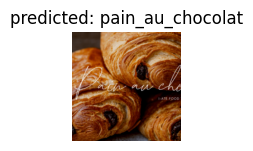

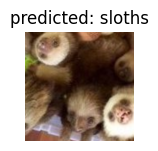

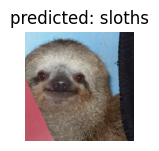

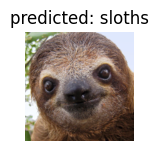

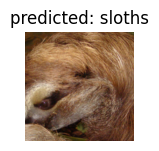

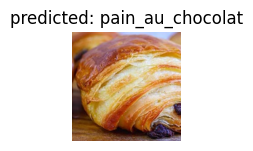

In [35]:
visualize_model(model_ft)

In [86]:
# to fine tune it for niche images
# Disable gradients for model_conv.parameters()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grid = False


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)


# Move the model to the device
model_conv = model_conv.to(device)


# Set criterion again
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_schedulr = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [14]:
# Train model_conv
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 

In [15]:
# Visualize model
visualize_model(model_conv)
plt.show()

# Where to next?

## Tutorials
- [Tutorial] [A beginner's guide to object detection](https://www.datacamp.com/tutorial/object-detection-guide)

## DataCamp courses
- [Course] [Introduction to Deep Learning with PyTorch](https://campus.datacamp.com/courses/introduction-to-deep-learning-with-pytorch/introduction-to-pytorch-a-deep-learning-library?ex=1)
- [Course: coming soon] Intermediate Deep Learning with PyTorch
- [Course: coming soon] Deep Learning for Images with PyTorch


## DataCamp tracks
- [Skill track] [Image Processing with Python ](https://app.datacamp.com/learn/skill-tracks/image-processing)